Copyright (c) Microsoft Corporation. All rights reserved.

Licensed under the MIT License.

![Impressions](https://PixelServer20190423114238.azurewebsites.net/api/impressions/NotebookVM/how-to-use-azureml/automated-machine-learning/forecasting-energy-demand/auto-ml-forecasting-energy-demand.png)

# Automated Machine Learning
_**Forecasting using the Energy Demand Dataset**_

## Contents
1. [Introduction](#introduction)
1. [Setup](#setup)
1. [Data and Forecasting Configurations](#data)
1. [Train](#train)
1. [Generate and Evaluate the Forecast](#forecast)

Advanced Forecasting
1. [Advanced Training](#advanced_training)
1. [Advanced Results](#advanced_results)

# Setup<a id="setup"></a>

In [1]:
import json
import logging

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import warnings
import os

# Squash warning messages for cleaner output in the notebook
warnings.showwarning = lambda *args, **kwargs: None

import azureml.core
from azureml.core import Experiment, Workspace, Dataset
from azureml.train.automl import AutoMLConfig
from datetime import datetime

This notebook is compatible with Azure ML SDK version 1.35.0 or later.

In [2]:
print("You are currently using version", azureml.core.VERSION, "of the Azure ML SDK")

You are currently using version 1.51.0 of the Azure ML SDK


In [3]:
ws = Workspace.from_config()

# choose a name for the run history container in the workspace
experiment_name = "automl-forecasting-energydemand"

# # project folder
# project_folder = './sample_projects/automl-forecasting-energy-demand'

experiment = Experiment(ws, experiment_name)

output = {}
output["Subscription ID"] = ws.subscription_id
output["Workspace"] = ws.name
output["Resource Group"] = ws.resource_group
output["Location"] = ws.location
output["Run History Name"] = experiment_name
output["SDK Version"] = azureml.core.VERSION
pd.set_option("display.max_colwidth", None)
outputDf = pd.DataFrame(data=output, index=[""])
outputDf.T

,
Subscription ID,ffc51280-6a38-41ea-8f5a-872347615ba2
Workspace,440proj
Resource Group,gpt5091-rg
Location,eastus2
Run History Name,automl-forecasting-energydemand
SDK Version,1.51.0


## Create or Attach existing AmlCompute


In [4]:
from azureml.core.compute import ComputeTarget, AmlCompute
from azureml.core.compute_target import ComputeTargetException

# Choose a name for your cluster.
amlcompute_cluster_name = "energy-cluster"

# Verify that cluster does not exist already
try:
    compute_target = ComputeTarget(workspace=ws, name=amlcompute_cluster_name)
    print("Found existing cluster, use it.")
except ComputeTargetException:
    compute_config = AmlCompute.provisioning_configuration(
        vm_size="STANDARD_DS12_V2", max_nodes=6
    )
    compute_target = ComputeTarget.create(ws, amlcompute_cluster_name, compute_config)

compute_target.wait_for_completion(show_output=True)

Found existing cluster, use it.
Succeeded
AmlCompute wait for completion finished

Minimum number of nodes requested have been provisioned


# Data<a id="data"></a>



In [5]:
target_column_name = "Target"
time_column_name = "Date"

The NYC Energy dataset is missing energy demand values for all datetimes later than August 10th, 2017 5AM. Below, we trim the rows containing these missing values from the end of the dataset.

In [6]:

file_path = os.path.join(os.getcwd(), 'BTC-USD_data.csv')
datastore = ws.get_default_datastore()
datastore.upload_files(files=[file_path], target_path='dataset/', overwrite=True)
dataset = Dataset.Tabular.from_delimited_files(path=(datastore, 'dataset/BTC-USD_data.csv'))
dataset = dataset.with_timestamp_columns(fine_grain_timestamp=time_column_name)

# Convert to pandas DataFrame for manipulation
df = dataset.to_pandas_dataframe()
df['Target'] = df['Close'].shift(-1)
# Remove duplicates based on the timestamp column
df.drop_duplicates(subset=[time_column_name], keep='first', inplace=True)

# Option 1: Save the modified DataFrame to a CSV file, then upload and create a new dataset
modified_file_path = 'modified_processed_data.csv'
df.to_csv(modified_file_path, index=False)
datastore.upload_files(files=[modified_file_path], target_path='dataset/', overwrite=True)
dataset = Dataset.Tabular.from_delimited_files(path=(datastore, 'dataset/modified_processed_data.csv'))
# Specify the timestamp column
dataset = dataset.with_timestamp_columns(fine_grain_timestamp=time_column_name)

"datastore.upload_files" is deprecated after version 1.0.69. Please use "FileDatasetFactory.upload_directory" instead. See Dataset API change notice at https://aka.ms/dataset-deprecation.


Uploading an estimated of 1 files
Uploading /mnt/batch/tasks/shared/LS_root/mounts/clusters/gpt50911/code/Users/gpt5091/BTCpred/src/model/forecasting-energy-demand/BTC-USD_data.csv
Uploaded /mnt/batch/tasks/shared/LS_root/mounts/clusters/gpt50911/code/Users/gpt5091/BTCpred/src/model/forecasting-energy-demand/BTC-USD_data.csv, 1 files out of an estimated total of 1
Uploaded 1 files
Uploading an estimated of 1 files
Uploading modified_processed_data.csv
Uploaded modified_processed_data.csv, 1 files out of an estimated total of 1
Uploaded 1 files


## Split the data into train and test sets

The first split we make is into train and test sets. Note that we are splitting on time. Data before and including August 8th, 2017 5AM will be used for training, and data after will be used for testing.

In [7]:
# split into train based on time
train = (
    dataset.time_before(datetime(2022, 5, 16), include_boundary=True)
    .to_pandas_dataframe()
    .reset_index(drop=True)
)
train.sort_values(time_column_name).tail(5)

,Date,Open,High,Low,Close,Adj Close,Volume,Target
1592,2022-05-12,28936.734375,30032.439453,26350.490234,29047.751953,29047.751953,66989173272,29283.103516
1593,2022-05-13,29030.910156,30924.802734,28782.330078,29283.103516,29283.103516,42841124537,30101.265625
1594,2022-05-14,29285.642578,30192.802734,28702.910156,30101.265625,30101.265625,28579868620,31305.113281
1595,2022-05-15,30098.585938,31308.191406,29527.740234,31305.113281,31305.113281,25835372065,29862.917969
1596,2022-05-16,31304.375000,31305.341797,29251.884766,29862.917969,29862.917969,32613897286,30425.857422


In [8]:
# split into test based on time
test = (
    dataset.time_between(datetime(2022, 5, 27), datetime(2023, 1, 1))
    .to_pandas_dataframe()
    .reset_index(drop=True)
)
test.head(5)

,Date,Open,High,Low,Close,Adj Close,Volume,Target
0,2022-05-27,29251.140625,29346.943359,28326.613281,28627.574219,28627.574219,36582005748,28814.900391
1,2022-05-28,28622.625000,28814.900391,28554.566406,28814.900391,28814.900391,35519577634,29445.957031
2,2022-05-29,29019.867188,29498.009766,28841.107422,29445.957031,29445.957031,18093886409,31726.390625
3,2022-05-30,29443.365234,31949.630859,29303.572266,31726.390625,31726.390625,39277993274,31792.310547
4,2022-05-31,31723.865234,32249.863281,31286.154297,31792.310547,31792.310547,33538210634,29799.080078


In [9]:
# register the splitted train and test data in workspace storage
from azureml.data.dataset_factory import TabularDatasetFactory

datastore = ws.get_default_datastore()
train_dataset = TabularDatasetFactory.register_pandas_dataframe(
    train, target=(datastore, "dataset/"), name="BTC_train"
)
test_dataset = TabularDatasetFactory.register_pandas_dataframe(
    test, target=(datastore, "dataset/"), name="BTC_test"
)

Validating arguments.
Arguments validated.
Successfully obtained datastore reference and path.
Uploading file to dataset//c1f554e1-e96e-4a09-a4a9-c0ac87f19f81/
Successfully uploaded file to datastore.
Creating and registering a new dataset.
Successfully created and registered a new dataset.
Validating arguments.
Arguments validated.
Successfully obtained datastore reference and path.
Uploading file to dataset//2c56bc49-11e9-4887-9621-b3d544d2b8e7/
Successfully uploaded file to datastore.
Creating and registering a new dataset.
Successfully created and registered a new dataset.


In [10]:
forecast_horizon = 48

This notebook uses the blocked_models parameter to exclude some models that take a longer time to train on this dataset. You can choose to remove models from the blocked_models list but you may need to increase the experiment_timeout_hours parameter value to get results.

In [11]:
from azureml.automl.core.forecasting_parameters import ForecastingParameters

forecasting_parameters = ForecastingParameters(
    time_column_name=time_column_name,
    forecast_horizon=forecast_horizon,
    freq="D",  # Set the forecast frequency to be hourly
    cv_step_size="auto",
)

automl_config = AutoMLConfig(
    task="forecasting",
    primary_metric="normalized_root_mean_squared_error",
    blocked_models=["ExtremeRandomTrees", "AutoArima", "Prophet"],
    experiment_timeout_hours=0.3,
    training_data=train_dataset,
    label_column_name=target_column_name,
    compute_target=compute_target,
    enable_early_stopping=True,
    n_cross_validations="auto",  # Feel free to set to a small integer (>=2) if runtime is an issue.
    verbosity=logging.INFO,
    forecasting_parameters=forecasting_parameters,
)

Call the `submit` method on the experiment object and pass the run configuration. Depending on the data and the number of iterations this can run for a while.
One may specify `show_output = True` to print currently running iterations to the console.

In [12]:
remote_run = experiment.submit(automl_config, show_output=False)

Submitting remote run.


Experiment,Id,Type,Status,Details Page,Docs Page
automl-forecasting-energydemand,AutoML_0eac0516-ca47-4af3-963d-bb649f060906,automl,NotStarted,Link to Azure Machine Learning studio,Link to Documentation


In [13]:
remote_run.wait_for_completion()

{'runId': 'AutoML_0eac0516-ca47-4af3-963d-bb649f060906',
 'target': 'energy-cluster',
 'status': 'Completed',
 'startTimeUtc': '2024-04-25T04:51:07.705912Z',
 'endTimeUtc': '2024-04-25T05:15:54.108914Z',
 'services': {},
 'warnings': [{'source': 'JasmineService',
   'message': 'Experiment timeout reached, hence experiment stopped. Current experiment timeout: 0 hour(s) 18 minute(s)'}],
 'properties': {'num_iterations': '1000',
  'training_type': 'TrainFull',
  'acquisition_function': 'EI',
  'primary_metric': 'normalized_root_mean_squared_error',
  'train_split': '0',
  'acquisition_parameter': '0',
  'num_cross_validation': 'auto',
  'target': 'energy-cluster',
  'AMLSettingsJsonString': '{"path":null,"name":"automl-forecasting-energydemand","subscription_id":"ffc51280-6a38-41ea-8f5a-872347615ba2","resource_group":"gpt5091-rg","workspace_name":"440proj","region":"eastus2","compute_target":"energy-cluster","spark_service":null,"azure_service":"remote","many_models":false,"pipeline_fetch

## Retrieve the Best Run details
Below we retrieve the best Run object from among all the runs in the experiment.

In [14]:
best_run = remote_run.get_best_child()
best_run

Experiment,Id,Type,Status,Details Page,Docs Page
automl-forecasting-energydemand,AutoML_0eac0516-ca47-4af3-963d-bb649f060906_5,,Completed,Link to Azure Machine Learning studio,Link to Documentation


## Featurization
We can look at the engineered feature names generated in time-series featurization via. the JSON file named 'engineered_feature_names.json' under the run outputs.

In [15]:
# Download the JSON file locally
best_run.download_file(
    "outputs/engineered_feature_names.json", "engineered_feature_names.json"
)
with open("engineered_feature_names.json", "r") as f:
    records = json.load(f)

records

['Open',
 'High',
 'Low',
 'Close',
 'Adj Close',
 'Volume',
 '_automl_target_col_WASNULL',
 'Open_WASNULL',
 'High_WASNULL',
 'Low_WASNULL',
 'Close_WASNULL',
 'Adj Close_WASNULL',
 'Volume_WASNULL',
 '_automl_year',
 '_automl_half',
 '_automl_quarter',
 '_automl_month',
 '_automl_day',
 '_automl_wday',
 '_automl_qday',
 '_automl_week']

### View featurization summary
You can also see what featurization steps were performed on different raw features in the user data. For each raw feature in the user data, the following information is displayed:

+ Raw feature name
+ Number of engineered features formed out of this raw feature
+ Type detected
+ If feature was dropped
+ List of feature transformations for the raw feature

In [16]:
# Download the featurization summary JSON file locally
best_run.download_file(
    "outputs/featurization_summary.json", "featurization_summary.json"
)

# Render the JSON as a pandas DataFrame
with open("featurization_summary.json", "r") as f:
    records = json.load(f)
fs = pd.DataFrame.from_records(records)

# View a summary of the featurization
fs[
    [
        "RawFeatureName",
        "TypeDetected",
        "Dropped",
        "EngineeredFeatureCount",
        "Transformations",
    ]
]

,RawFeatureName,TypeDetected,Dropped,EngineeredFeatureCount,Transformations
0,Open,Numeric,No,2,"[MedianImputer, ImputationMarker]"
1,High,Numeric,No,2,"[MedianImputer, ImputationMarker]"
2,Low,Numeric,No,2,"[MedianImputer, ImputationMarker]"
3,Close,Numeric,No,2,"[MedianImputer, ImputationMarker]"
4,Adj Close,Numeric,No,2,"[MedianImputer, ImputationMarker]"
5,Volume,Numeric,No,2,"[MedianImputer, ImputationMarker]"
6,_automl_target_col,Numeric,No,1,[ImputationMarker]
7,Date,DateTime,No,8,[DateTimeTransformer]


# Forecasting<a id="forecast"></a>

Now that we have retrieved the best pipeline/model, it can be used to make predictions on test data. We will do batch scoring on the test dataset which should have the same schema as training dataset.

The inference will run on a remote compute. In this example, it will re-use the training compute.

In [17]:
test_experiment = Experiment(ws, experiment_name + "_inference")

### Retrieving forecasts from the model
We have created a function called `run_forecast` that submits the test data to the best model determined during the training run and retrieves forecasts. This function uses a helper script `forecasting_script` which is uploaded and expecuted on the remote compute.

In [18]:
from run_forecast import run_remote_inference

remote_run_infer = run_remote_inference(
    test_experiment=test_experiment,
    compute_target=compute_target,
    train_run=best_run,
    test_dataset=test_dataset,
    target_column_name=target_column_name,
)
remote_run_infer.wait_for_completion(show_output=False)

# download the inference output file to the local machine
remote_run_infer.download_file("outputs/predictions.csv", "predictions.csv")

### Evaluate
To evaluate the accuracy of the forecast, we'll compare against the actual sales quantities for some select metrics, included the mean absolute percentage error (MAPE). For more metrics that can be used for evaluation after training, please see [supported metrics](https://docs.microsoft.com/en-us/azure/machine-learning/how-to-understand-automated-ml#regressionforecasting-metrics), and [how to calculate residuals](https://docs.microsoft.com/en-us/azure/machine-learning/how-to-understand-automated-ml#residuals).

In [19]:
# load forecast data frame
fcst_df = pd.read_csv("predictions.csv", parse_dates=[time_column_name])
fcst_df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Target,prediction_interval,predicted
0,2022-05-27,29251.140625,29346.943359,28326.613281,28627.574219,28627.574219,36582005748,28814.900391,"[25527.01488769559, 31808.866511518412]",28667.940700
1,2022-05-28,28622.625000,28814.900391,28554.566406,28814.900391,28814.900391,35519577634,29445.957031,"[24383.44002832713, 33267.319791552814]",28825.379910
2,2022-05-29,29019.867188,29498.009766,28841.107422,29445.957031,29445.957031,18093886409,31726.390625,"[23973.2097700972, 34853.695948167384]",29413.452859
3,2022-05-30,29443.365234,31949.630859,29303.572266,31726.390625,31726.390625,39277993274,31792.310547,"[25377.554238458266, 37941.25748610391]",31659.405862
4,2022-05-31,31723.865234,32249.863281,31286.154297,31792.310547,31792.310547,33538210634,29799.080078,"[24755.5320395377, 38802.17929497297]",31778.855667


[Test data scores]

root_mean_squared_log_error:   0.033
normalized_mean_absolute_error:   0.028
normalized_root_mean_squared_log_error:   0.048
mean_absolute_percentage_error:   2.122
median_absolute_error:   232.229
root_mean_squared_error:   719.830
explained_variance:   0.956
normalized_root_mean_squared_error:   0.045
r2_score:   0.956
mean_absolute_error:   442.064
spearman_correlation:   0.955
normalized_median_absolute_error:   0.015


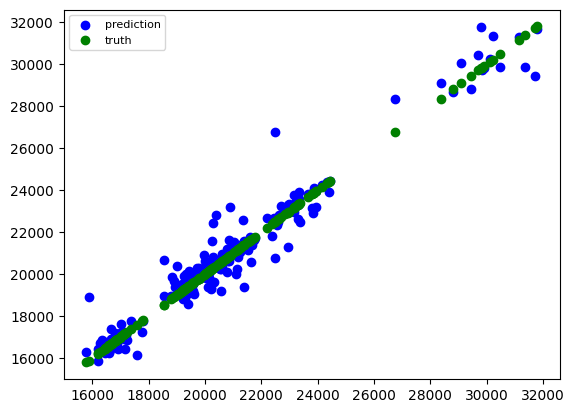

In [20]:
from azureml.automl.core.shared import constants
from azureml.automl.runtime.shared.score import scoring
from matplotlib import pyplot as plt

# use automl metrics module
scores = scoring.score_regression(
    y_test=fcst_df[target_column_name],
    y_pred=fcst_df["predicted"],
    metrics=list(constants.Metric.SCALAR_REGRESSION_SET),
)

print("[Test data scores]\n")
for key, value in scores.items():
    print("{}:   {:.3f}".format(key, value))

# Plot outputs
%matplotlib inline
test_pred = plt.scatter(fcst_df[target_column_name], fcst_df["predicted"], color="b")
test_test = plt.scatter(
    fcst_df[target_column_name], fcst_df[target_column_name], color="g"
)
plt.legend(
    (test_pred, test_test), ("prediction", "truth"), loc="upper left", fontsize=8
)
plt.show()

# Advanced Training <a id="advanced_training"></a>
We did not use lags in the previous model specification. In effect, the prediction was the result of a simple regression on date, time series identifier columns and any additional features. This is often a very good prediction as common time series patterns like seasonality and trends can be captured in this manner. Such simple regression is horizon-less: it doesn't matter how far into the future we are predicting, because we are not using past data. In the previous example, the horizon was only used to split the data for cross-validation.

### Using lags and rolling window features
Now we will configure the target lags, that is the previous values of the target variables, meaning the prediction is no longer horizon-less. We therefore must still specify the `forecast_horizon` that the model will learn to forecast. The `target_lags` keyword specifies how far back we will construct the lags of the target variable, and the `target_rolling_window_size` specifies the size of the rolling window over which we will generate the `max`, `min` and `sum` features.

This notebook uses the blocked_models parameter to exclude some models that take a longer time to train on this dataset.  You can choose to remove models from the blocked_models list but you may need to increase the iteration_timeout_minutes parameter value to get results.

In [21]:
from azureml.automl.core.forecasting_parameters import ForecastingParameters

advanced_forecasting_parameters = ForecastingParameters(
    time_column_name=time_column_name,
    forecast_horizon=forecast_horizon,
    target_lags=12,
    target_rolling_window_size=4,
    cv_step_size="auto",
)

automl_config = AutoMLConfig(
    task="forecasting",
    primary_metric="normalized_root_mean_squared_error",
    blocked_models=[
        "ElasticNet",
        "ExtremeRandomTrees",
        "GradientBoosting",
        "XGBoostRegressor",
        "ExtremeRandomTrees",
        "AutoArima",
        "Prophet",
    ],  # These models are blocked for tutorial purposes, remove this for real use cases.
    experiment_timeout_hours=0.3,
    training_data=train_dataset,
    label_column_name=target_column_name,
    compute_target=compute_target,
    enable_early_stopping=True,
    n_cross_validations="auto",  # Feel free to set to a small integer (>=2) if runtime is an issue.
    verbosity=logging.INFO,
    forecasting_parameters=advanced_forecasting_parameters,
)

We now start a new remote run, this time with lag and rolling window featurization. AutoML applies featurizations in the setup stage, prior to iterating over ML models. The full training set is featurized first, followed by featurization of each of the CV splits. Lag and rolling window features introduce additional complexity, so the run will take longer than in the previous example that lacked these featurizations.

In [22]:
advanced_remote_run = experiment.submit(automl_config, show_output=False)

Submitting remote run.


Experiment,Id,Type,Status,Details Page,Docs Page
automl-forecasting-energydemand,AutoML_64861d04-f762-4a18-b219-563780a84f46,automl,NotStarted,Link to Azure Machine Learning studio,Link to Documentation


In [23]:
advanced_remote_run.wait_for_completion()

{'runId': 'AutoML_64861d04-f762-4a18-b219-563780a84f46',
 'target': 'energy-cluster',
 'status': 'Completed',
 'startTimeUtc': '2024-04-16T15:32:54.45054Z',
 'endTimeUtc': '2024-04-16T15:54:15.215884Z',
 'services': {},
 'warnings': [{'source': 'JasmineService',
   'message': 'Experiment timeout reached, hence experiment stopped. Current experiment timeout: 0 hour(s) 18 minute(s)'}],
 'properties': {'num_iterations': '1000',
  'training_type': 'TrainFull',
  'acquisition_function': 'EI',
  'primary_metric': 'normalized_root_mean_squared_error',
  'train_split': '0',
  'acquisition_parameter': '0',
  'num_cross_validation': 'auto',
  'target': 'energy-cluster',
  'AMLSettingsJsonString': '{"path":null,"name":"automl-forecasting-energydemand","subscription_id":"ffc51280-6a38-41ea-8f5a-872347615ba2","resource_group":"gpt5091-rg","workspace_name":"440proj","region":"eastus2","compute_target":"energy-cluster","spark_service":null,"azure_service":"remote","many_models":false,"pipeline_fetch_

### Retrieve the Best Run details

In [24]:
best_run_lags = advanced_remote_run.get_best_child()
best_run_lags

Experiment,Id,Type,Status,Details Page,Docs Page
automl-forecasting-energydemand,AutoML_64861d04-f762-4a18-b219-563780a84f46_20,azureml.scriptrun,Completed,Link to Azure Machine Learning studio,Link to Documentation


In [25]:
from run_forecast import run_remote_inference
test_experiment_advanced = Experiment(ws, experiment_name + "_inference_advanced")
advanced_remote_run_infer = run_remote_inference(
    test_experiment=test_experiment_advanced,
    compute_target=compute_target,
    train_run=best_run_lags,
    test_dataset=test_dataset,
    target_column_name=target_column_name,
    inference_folder="./forecast_advanced",
)
advanced_remote_run_infer.wait_for_completion(show_output=False)

# download the inference output file to the local machine
advanced_remote_run_infer.download_file(
    "outputs/predictions.csv", "predictions_advanced.csv"
)

In [26]:
fcst_adv_df = pd.read_csv("predictions_advanced.csv", parse_dates=[time_column_name])
fcst_adv_df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Target,prediction_interval,predicted
0,2022-01-01,46311.746094,47827.312500,46288.484375,47686.812500,47686.812500,24582667004,47345.218750,"[45482.65610923982, 49596.611337662616]",47539.633723
1,2022-01-02,47680.925781,47881.406250,46856.937500,47345.218750,47345.218750,27951569547,46458.117188,"[45258.023651365445, 49371.97887978824]",47315.001266
2,2022-01-03,47343.542969,47510.726562,45835.964844,46458.117188,46458.117188,33071628362,45897.574219,"[44465.61515600211, 48579.57038442491]",46522.592770
3,2022-01-04,46458.851562,47406.546875,45752.464844,45897.574219,45897.574219,42494677905,43569.003906,"[43848.788978731944, 47962.74420715474]",45905.766593
4,2022-01-05,45899.359375,46929.046875,42798.222656,43569.003906,43569.003906,36851084859,43160.929688,"[41742.295322175254, 45856.25055059805]",43799.272936


[Test data scores]

root_mean_squared_error:   1018.703
mean_absolute_error:   661.438
normalized_mean_absolute_error:   0.021
r2_score:   0.990
median_absolute_error:   371.737
spearman_correlation:   0.985
normalized_median_absolute_error:   0.012
normalized_root_mean_squared_error:   0.032
mean_absolute_percentage_error:   2.314
normalized_root_mean_squared_log_error:   0.031
explained_variance:   0.990
root_mean_squared_log_error:   0.034


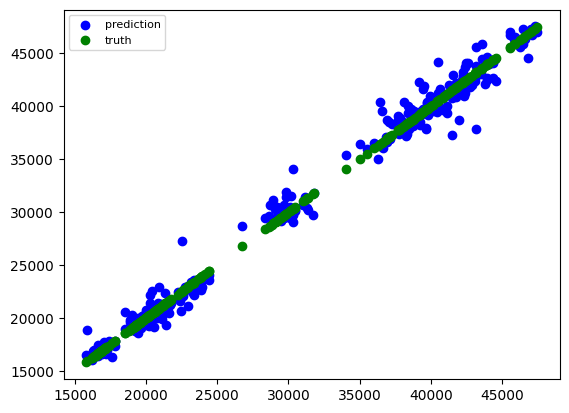

In [27]:
from azureml.automl.core.shared import constants
from azureml.automl.runtime.shared.score import scoring
from matplotlib import pyplot as plt

# use automl metrics module
scores = scoring.score_regression(
    y_test=fcst_adv_df[target_column_name],
    y_pred=fcst_adv_df["predicted"],
    metrics=list(constants.Metric.SCALAR_REGRESSION_SET),
)

print("[Test data scores]\n")
for key, value in scores.items():
    print("{}:   {:.3f}".format(key, value))

# Plot outputs
%matplotlib inline
test_pred = plt.scatter(
    fcst_adv_df[target_column_name], fcst_adv_df["predicted"], color="b"
)
test_test = plt.scatter(
    fcst_adv_df[target_column_name], fcst_adv_df[target_column_name], color="g"
)
plt.legend(
    (test_pred, test_test), ("prediction", "truth"), loc="upper left", fontsize=8
)
plt.show()